In [1]:
import time
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import torch
import pytorch3d.ops
from plyfile import PlyData, PlyElement
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
from argparse import ArgumentParser, Namespace
import cv2
from tqdm import tqdm
from arguments import ModelParams, PipelineParams, ModelHiddenParams
from scene import Scene, GaussianModel
from gaussian_renderer import render, render_contrastive_feature, render_segmentation, render_mask
from segment_anything import (SamAutomaticMaskGenerator, SamPredictor, sam_model_registry)
from utils.sh_utils import SH2RGB
import imageio
from utils.segment_utils import *

%load_ext autoreload
%autoreload 2

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


## Hyper-parameters

In [2]:
FEATURE_DIM = 32

DATA_ROOT = './data/hypernerf/chickchicken'
# the model path, same to the --model_path in the training, after train_scene.py this folder will be created but named randomly
MODEL_PATH = './output/hypernerf/chickchicken'
GAUSSIAN_ITERATION = 14000

SAM_PROJ_PATH = os.path.join(MODEL_PATH, f'point_cloud/iteration_{str(GAUSSIAN_ITERATION)}/sam_proj.pt')
NEG_PROJ_PATH = os.path.join(MODEL_PATH, f'point_cloud/iteration_{str(GAUSSIAN_ITERATION)}/neg_proj.pt')
FEATURE_PCD_PATH = os.path.join(MODEL_PATH, f'point_cloud/iteration_{str(GAUSSIAN_ITERATION)}/feature_point_cloud.ply')
SCENE_PCD_PATH = os.path.join(MODEL_PATH, f'point_cloud/iteration_{str(GAUSSIAN_ITERATION)}/scene_point_cloud.ply')

# SAM_ARCH = 'vit_h'
# SAM_CKPT_PATH = '/data/sxj/dependencies/sam_ckpt/sam_vit_h_4b8939.pth'

## Data and Model Preparation

In [3]:
parser = ArgumentParser(description="Render script parameters")
model = ModelParams(parser, sentinel=True)
# op = OptimizationParams(parser)
pipeline = PipelineParams(parser)
hp = ModelHiddenParams(parser)
parser.add_argument("--iteration", default=-1, type=int)
parser.add_argument('--mode', default='feature', choices=['scene', 'feature'])
parser.add_argument("--configs", type=str, default = "./arguments/hypernerf/chicken.py")
# parser.add_argument('--precomputed_mask', default=None, type=str)
args = get_combined_args(parser, MODEL_PATH, 'feature')
if args.configs:
    import mmcv
    from utils.params_utils import merge_hparams
    config = mmcv.Config.fromfile(args.configs)
    args = merge_hparams(args, config)

dataset = model.extract(args)
hyperparam = hp.extract(args)
dataset.object_masks = True
dataset.need_gt_masks = True

gaussians = GaussianModel(dataset.sh_degree, args.mode, hyperparam, dataset.feature_dim)
scene = Scene(dataset, gaussians, load_iteration=args.iteration, mode=args.mode)

Looking for config file in ./output/hypernerf/chickchicken/feature_cfg_args
Config file found at: ./output/hypernerf/chickchicken/feature_cfg_args


mode:  feature
Loading trained model at iteration 14000
load finished


114it [00:00, 58126.75it/s]

format finished
Loading Training Cameras
Loading Test Cameras
Loading Video Cameras
Deformation Net Set aabb [ 81.62185669  25.49359322 291.8190918 ] [ -34.72369003 -174.75157166   12.67879772]
Voxel Plane: set aabb= Parameter containing:
tensor([[  81.6219,   25.4936,  291.8191],
        [ -34.7237, -174.7516,   12.6788]])


loading model from exists./output/hypernerf/chickchicken/point_cloud/iteration_14000


## Begin Segmentation

In [4]:
bg_color = [1, 1, 1] if dataset.white_background else [0, 0, 0]
bg_color = torch.tensor(bg_color, dtype=torch.float32, device="cuda")
bg_feature = [0 for i in range(FEATURE_DIM)]
bg_feature = torch.tensor(bg_feature, dtype=torch.float32, device="cuda")

video_cameras = [i for i in scene.getVideoCameras()]
cam_type = scene.dataset_type
print("There are",len(video_cameras),"views in the dataset.")

There are 456 views in the dataset.


In [5]:
def plot(img_list, axis=False):
    l = len(img_list)
    for i, img in enumerate(img_list):
        plt.subplot(1, 3, i+1)
        plt.imshow(img)
        if axis == False:
            plt.axis('off')
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


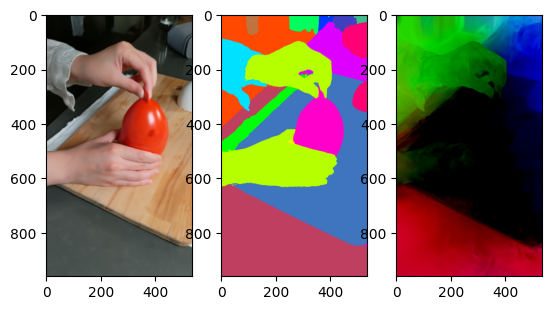

In [6]:
ref_img_camera_id = 0
mask_img_camera_id = 0
ref_view = video_cameras[ref_img_camera_id]

with torch.no_grad():
    rendering = render(ref_view, gaussians, pipeline, bg_color, cam_type=cam_type)["render"]
    img = to8b(rendering).transpose(1,2,0)
    # img = cv2.resize(img, dsize=(1024,1024), fx=1, fy=1, interpolation=cv2.INTER_LINEAR)
    objects = ref_view.objects
    
    identity_encoding = render_contrastive_feature(ref_view, gaussians, pipeline, bg_feature)["render"]
    logits = gaussians._classifier(identity_encoding)
    pred_obj = torch.argmax(logits,dim=0).cpu().numpy()
    
    import numpy as np
    from sklearn.decomposition import PCA
    identity_encoding = torch.nn.functional.normalize(identity_encoding, dim=0)
    X = identity_encoding.permute([1, 2, 0]).flatten(0, 1).cpu().numpy()
    np.random.seed(6)
    pca = PCA(n_components=3)
    pca.fit(X)
    X_rgb = pca.transform(X).reshape(*identity_encoding.shape[-2:], 3)
    # X_rgb = 255 * (X_rgb - X_rgb.min()) / (X_rgb.max() - X_rgb.min())
    
    plot([img, visualize_obj(pred_obj), X_rgb], axis=True)

In [7]:
# pred_obj[700, 400]

In [8]:
egg_id = 37
hand_id = 23
board_id = 22

selected_id = board_id

tensor(26332, device='cuda:0')


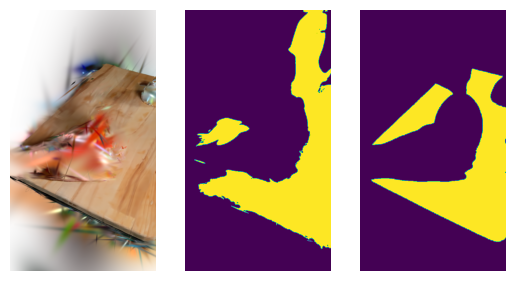

In [9]:
selected_obj_ids = torch.tensor(selected_id).cuda()
gt_mask = (objects == selected_id).int()
with torch.no_grad():
    means3D = gaussians.get_xyz
    ts = torch.tensor(ref_view.time).to(means3D.device).repeat(means3D.shape[0],1)
    
    identity_encoding = gaussians._mlp(means3D, ts)
    logits3d = gaussians._classifier(identity_encoding.unsqueeze(1).permute(2, 0, 1))
    prob_obj3d = torch.softmax(logits3d, dim=0)
    obj3d = torch.argmax(prob_obj3d, dim=0)
    hard_mask3d = (obj3d == selected_obj_ids).squeeze()
    soft_mask3d =  (prob_obj3d[selected_obj_ids, :, :] > 0.3).squeeze()
    mask3d = soft_mask3d # hard_mask3d & soft_mask3d
    # mask3d = mask.any(dim=0).squeeze()
    print(mask3d.count_nonzero())
    
    # plot
    target_seg = render_segmentation(ref_view, gaussians, pipeline, bg_color, mask3d.bool())["render"]
    target_img_seg = to8b(target_seg.detach()).transpose(1,2,0)
    rendered_mask = render_mask(ref_view, gaussians, pipeline, bg_color, precomputed_mask=mask3d.float())["mask"]
    rendered_mask = rendered_mask.squeeze().detach().cpu() > 0.1
    plot([target_img_seg, rendered_mask, gt_mask.detach().cpu()])

In [10]:
from utils.segment_utils import *

render_images = []
with torch.no_grad():
    for idx, view in enumerate(tqdm(video_cameras, desc="Rendering progress")):
        if idx == 0: time1 = time.time()
        
        means3D = gaussians.get_xyz
        ts = torch.tensor(view.time).to(means3D.device).repeat(means3D.shape[0],1)
        
        identity_encoding = gaussians._mlp(means3D, ts)
        logits3d = gaussians._classifier(identity_encoding.unsqueeze(1).permute(2, 0, 1))
        prob_obj3d = torch.softmax(logits3d, dim=0)
        obj3d = torch.argmax(prob_obj3d, dim=0)
        hard_mask3d = (obj3d == selected_obj_ids).squeeze()
        soft_mask3d = (prob_obj3d[selected_obj_ids, :, :] > 0.3).squeeze()
        mask3d = soft_mask3d # hard_mask3d & soft_mask3d
        
        rendering = render_segmentation(view, gaussians, pipeline, bg_color, ~mask3d.bool())["render"]
        render_images.append(to8b(rendering.detach()).transpose(1,2,0))

time2 = time.time()
print("FPS:", len(video_cameras) / (time2 - time1))
torch.cuda.empty_cache()
    
imageio.mimwrite(os.path.join(MODEL_PATH, 'video', "ours_{}".format(GAUSSIAN_ITERATION), 'video_seg_board_remove.mp4'), render_images, fps=30)

Rendering progress:   0%|          | 0/456 [00:00<?, ?it/s]

Rendering progress: 100%|██████████| 456/456 [00:09<00:00, 49.52it/s]


FPS: 49.520299592482104


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (536, 960) to (544, 960) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x6485f80] Warning: data is not aligned! This can lead to a speed loss


## Create a mask_table.

In [11]:
train_cams = scene.getTrainCameras()
viewpoint_stack = [i for i in train_cams]
gaussians.create_mask_table(len(viewpoint_stack))

In [16]:
with torch.no_grad():
    time1 = time.time()
    for idx, view in enumerate(tqdm(viewpoint_stack)):
        gaussians._time_map[idx] = view.time
        
        means3D = gaussians.get_xyz
        ts = torch.tensor(view.time).to(means3D.device).repeat(means3D.shape[0],1)
        identity_encoding = gaussians._mlp(means3D, ts)
        logits3d = gaussians._classifier(identity_encoding.unsqueeze(1).permute(2, 0, 1))
        prob_obj3d = torch.softmax(logits3d, dim=0)
        obj3d = torch.argmax(prob_obj3d, dim=0)
        # hard_mask3d = (obj3d == selected_obj_ids).squeeze()
        soft_mask3d =  (prob_obj3d[selected_id, :, :] > 0.3).squeeze()
        mask3d = soft_mask3d # hard_mask3d & soft_mask3d
        gt_mask = (view.objects == selected_id).int().cuda()
        
        # remove outliers
        mask3d[mask3d.clone()] = points_inside_convex_hull(gaussians.get_xyz, mask3d, outlier_factor=3.0)
        # _, filtered_mask = statistical_filtering(gaussians.get_xyz, mask3d, max_time=1)
        # mask3d[mask3d.clone()] = filtered_mask
        
        render_pkg = render_segmentation(view, gaussians, pipeline, bg_color, mask3d.bool())
        # remove Gaussians with extremely large radii
        radii = render_pkg["radii"].float()
        mask = (radii <= radii.mean() + 6 * radii.std())
        mask3d[mask3d.clone()] = mask
        gaussians._mask_table[idx] = mask3d
        
        # remove Gaussians outside the gt_mask
        points2d = render_pkg['points2d'][mask].round().long()
        mask = (points2d[:, 1] >= 0) & (points2d[:, 1] < view.image_height) & (points2d[:, 0] >= 0) & (points2d[:, 0] < view.image_width)
        mask3d[mask3d.clone()] = mask

        visible_points2d = points2d[mask]
        points2d_values = gt_mask[visible_points2d[:, 1], visible_points2d[:, 0]]
        gaussians._mask_table[idx][mask3d] = (points2d_values == 1).float()
        
    time2 = time.time()
    print("time:", time2 - time1)

  0%|          | 0/114 [00:00<?, ?it/s]

100%|██████████| 114/114 [00:02<00:00, 50.72it/s]

time: 2.2497761249542236


In [ ]:
gaussians.save_mask_table(os.path.join(MODEL_PATH, "segment_results"))
gaussians.save_seg_gs(os.path.join(MODEL_PATH, "segment_results"))

## Inference

In [17]:
from utils.segment_utils import *

render_images = []
for idx, view in enumerate(tqdm(video_cameras, desc="Rendering progress")):
    if idx == 0: time1 = time.time()
    
    # nearest interpolate
    diff = torch.abs(gaussians._time_map - view.time)
    index = torch.argmin(diff)
    mask = gaussians._mask_table[index]
        
    rendering = render_segmentation(view, gaussians, pipeline, bg_color, mask.bool())["render"]
    render_images.append(to8b(rendering.detach()).transpose(1,2,0))

time2 = time.time()
print("FPS:", len(video_cameras) / (time2 - time1))
torch.cuda.empty_cache()
    
imageio.mimwrite(os.path.join(MODEL_PATH, 'video', "ours_{}".format(GAUSSIAN_ITERATION), 'video_seg_board.mp4'), render_images, fps=30)

Rendering progress:   0%|          | 0/456 [00:00<?, ?it/s]

Rendering progress: 100%|██████████| 456/456 [00:03<00:00, 115.77it/s]
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (536, 960) to (544, 960) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


FPS: 115.7348413495102


[swscaler @ 0x67d6b40] Warning: data is not aligned! This can lead to a speed loss


## Quantative Results

In [17]:
test_views = [i for i in scene.getTestCameras()]

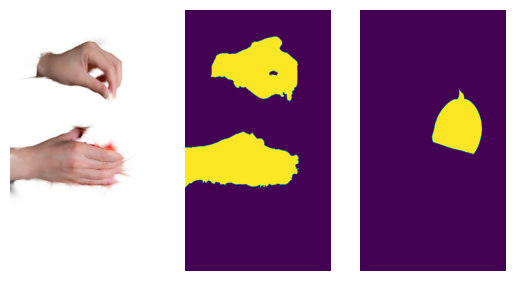

In [22]:
target_view = test_views[0]
with torch.no_grad():
    diff = torch.abs(gaussians._time_map - target_view.time)
    index = torch.argmin(diff)
    mask = gaussians._mask_table[index]

    target_seg = render_segmentation(target_view, gaussians, pipeline, bg_color, mask.bool())["render"]
    target_img_seg = to8b(target_seg.detach()).transpose(1,2,0)
    rendered_mask = render_mask(target_view, gaussians, pipeline, bg_color, precomputed_mask=mask.float())["mask"]
    rendered_mask = rendered_mask.squeeze().detach().cpu() > 0.1
plt.subplot(1, 3, 1)
plt.imshow(target_img_seg)
plt.axis("off")
plt.subplot(1, 3, 2)
plt.imshow(rendered_mask)
plt.axis("off")
plt.subplot(1, 3, 3)
plt.imshow(target_view.gt_mask.squeeze().int())
plt.axis('off')
plt.show()

In [54]:
miou = 0.
macc = 0.
for idx, view in enumerate(tqdm(test_views)):
     #! render
     rendered_mask = render_mask(view, gaussians, pipeline, bg_color, precomputed_mask=final_mask3d.float())["mask"]
     rendered_mask = rendered_mask.squeeze().detach().cpu() > 0.5
     # rendered_mask = rendered_mask.int()

     gt_mask = view.gt_mask.bool()
     
     #! metrics
     iou = (rendered_mask & gt_mask).sum() / (rendered_mask | gt_mask).sum()
     # iou += ((~rendered_mask) & (~gt_mask)).sum() / ((~rendered_mask) | (~gt_mask)).sum()
     # iou /= 2
     acc = (rendered_mask == gt_mask).count_nonzero() / gt_mask.numel()
     miou += iou
     macc += acc
     # print(miou)
     # break
     
     torch.cuda.empty_cache()

miou /= len(test_views)
macc /= len(test_views)
print("mIoU: %.4f" % (miou * 100))
print("mAcc: %.4f" % (macc * 100))

  0%|          | 0/134 [00:00<?, ?it/s]

100%|██████████| 134/134 [00:04<00:00, 28.09it/s]

mIoU: 57.3461
mAcc: 97.1317
